<a href="https://colab.research.google.com/github/Lautz97/Home_Stuff_Classifier_using_CNN/blob/main/ML_hw_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2

Dataset : 
* containers/food_tray 
* tableware/salad_plate 
* drinks/Juice_bottle 
* cutlery/plastic_spoon
* fruits/Tangerines
* snacks/Pretzels
* food/canned_vegetables
* cleaning_stuff/Glass_Cleaners



In [1]:
!pip install ipython-autotime
%load_ext autotime

from google.colab import files
import json
import pandas as pd
import matplotlib.pyplot as plt

import re

print("importing libraries.......done")

importing libraries.......done
time: 3.06 ms


In [2]:
%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.3.0
Keras version 2.4.3
Found GPU at: /device:GPU:0
time: 6.71 s


In [3]:
#@title # Variable settings { run: "auto" }
#@markdown To customize:

#@markdown ### Paths

# in case of retrieving data from g_drive the drive will be mounted
# specify where here
drive_mount_path = "/content/drive" #@param {type:"string"} 
zipped_images = "/My Drive/MLHW2/zipped_images" #@param {type:"string"}
# now specify the directory of the dataset 
# unzipped_images = "/My Drive/MLHW2" #@param {type:"string"}

# @markdown ### Variables
# @markdown resized edge length
edge_len =  "256" #@param ["128", "256", "512"]{type:"string"}
edge_len = int(edge_len)

# @markdown batch size
batch =  "32" #@param ["16", "32", "64"]{type:"string"}
batch = int(batch)

# @markdown Select Network Model in the Model Parameters cell

print("done!")

done!
time: 5.6 ms


# Dataset Selection

Upload dataset from file system, or take it from gdrive(best option).

In [4]:
from google.colab import drive

drive.mount(drive_mount_path, force_remount = True)

zip_path = drive_mount_path + zipped_images
!cp -r "{zip_path}" .
!unzip -q ./zipped_images/\* -d ./imgs
!rm -r ./zipped_images
!rm -r ./sample_data 

print()

Mounted at /content/drive

8 archives were successfully processed.

time: 27.5 s


# Preprocessing Dataset

In [5]:
directory = "./imgs"

datagen = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=directory,
    batch_size=batch,
    target_size=(edge_len, edge_len),
    class_mode="categorical",
    color_mode="rgb",
    subset="training",
    interpolation="bilinear",
    shuffle=True,
)
test_generator = datagen.flow_from_directory(
    directory=directory,
    batch_size=batch,
    target_size=(edge_len, edge_len),
    class_mode="categorical",
    color_mode="rgb",
    subset="validation",
    interpolation="bilinear",
    shuffle=False,
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 6980 images belonging to 8 classes.
Found 1742 images belonging to 8 classes.
Image input (256, 256, 3)
Classes: ['Glass_Cleaners', 'Juice_bottle', 'Pretzels', 'Tangerines', 'canned_vegetables', 'food_tray', 'plastic_spoon', 'salad_plate']
Loaded 6980 training samples from 8 classes.
Loaded 1742 test samples from 8 classes.
time: 433 ms


canned_vegetables


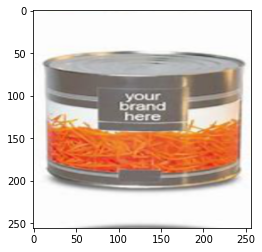

Glass_Cleaners


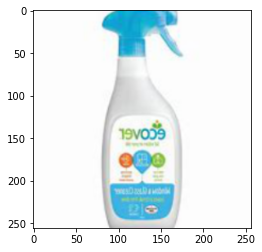

plastic_spoon


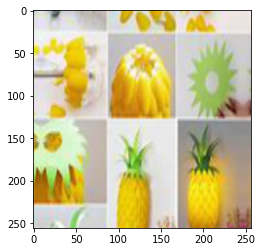

time: 1.06 s


In [6]:
#just for fun, stolen from ex11
import matplotlib.pyplot as plt

n = 3
x,y = train_generator.next()
# x,y size is train_generator.batch_size

for i in range(0,n):
    image = x[i]
    label = y[i].argmax()  # categorical from one-hot-encoding
    print(classnames[label])
    plt.imshow(image)
    plt.show()

# Convolutional Neural Network
Contruction layer by layer of the selected CNN models

In [7]:
#@title # ConvNet Setup
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

def ConvNet(name="ConvNet"): 
  # @markdown #### Sequential Model
  model = Sequential()

  # @markdown C1: Conv2D 32 with "relu" activation function
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(edge_len, edge_len, 3)))
  # @markdown M2: 2D MaxPooling
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # @markdown C3: Conv2D 32 with "relu" activation function
  model.add(Conv2D(32, (3, 3), activation='relu'))
  #@markdown M4: 2D MaxPooling
  model.add(MaxPooling2D(pool_size=(2, 2)))

  #@markdown C5: Conv2D 64 and "relu" activation function
  model.add(Conv2D(64, (3, 3), activation='relu'))
  #@markdown M6: 2D MaxPooling
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # the model so far outputs 3D feature maps (height, width, features)

  # @markdown 6.5: Flatten to convert the 3D feature map to a 1D vector
  model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

  # @markdown F7: Fully connected, 64 units with "relu" activation function
  model.add(Dense(64, activation='relu'))

  # @markdown D8: Dropout 0.5 to prevent overfitting
  model.add(Dropout(0.5))

  # @markdown F9: Fully connected, 1 unit with "sigmoid" activation function
  model.add(Dense(8, activation='sigmoid'))

  return model

# @markdown Use adam or SGD as optimizer and categorical_crossentropy as loss function

time: 31.2 ms


In [8]:
#@title #LeNet model Setup

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten,\
                         Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers

def LeNet(name="LeNet"):
    
    # @markdown #### Sequential Model
    model = Sequential()
    
    # @markdown C1: Convolutional 6 kernels 5x5
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(edge_len, edge_len, 3), padding='same'))
    
    # @markdown S2: Average Pooling 2x2 stride 2x2
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    # @markdown C3: Convolutional 16 kernels 5x5
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    
    # @markdown S4: Average Pooling 2x2 stride 2x2
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    
    # @markdown C5: Convolutional 120 kernels 5x5
    model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    
    # @markdown 5.5: Flatten to convert n-D  feature map in 1D vector
    model.add(Flatten())
    
    # @markdown F6: Fully connected, 84 units
    model.add(Dense(84, activation='tanh'))
 
    # @markdown F7: Fully connected, 8 units
    model.add(Dense(8, activation='softmax'))
    
    return model
 
# @markdown Use adam or SGD as optimizer and categorical_crossentropy as loss function

time: 22 ms


In [37]:
# @markdown # Model Parameters

# @markdown #### Select Model
selected_model =  "ConvNet" #@param ["LeNet", "ConvNet"]{type:"string"}

# create the model
model_list = {
    "ConvNet": ConvNet,
    "LeNet": LeNet
}
net_model = model_list.get(selected_model)()
net_model.summary()

# @markdown select optimizer
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
optimizer =  "Adam" #@param ["Adadelta", "Adagrad", "Adam", "Adamax", "Ftrl", "Nadam", "optimizer", "RMSprop", "SGD"]{type:"string"}

# @markdown select loss function
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
loss_fun =  "categorical_crossentropy" #@param ["KLD", "MAE", "MAPE", "MSE", "MSLE", "binary_crossentropy", "categorical_crossentropy", "categorical_hinge", "cosine_similarity", "hinge", "huber", "kld", "poisson"]{type:"string"}

#metrics from keras.metrics are.... broken(?)

net_model.compile(loss = loss_fun,
              optimizer = optimizer,
              metrics = ['accuracy'])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 57600)            

# Train it!
gym session

In [38]:
train_cnn = False # @param {type: "boolean"}
save_model = False # @param {type: "boolean"}
load_model = True # @param {type: "boolean"}

n_epochs = 100 # @param {type: "integer"}

name = selected_model +"_"+ str(n_epochs) +"_"+optimizer+"_"+loss_fun  
print(name)

if(train_cnn):
  history = net_model.fit(
          train_generator,
          steps_per_epoch=2000 // batch,
          epochs=n_epochs, #50 takes too long
          validation_data=test_generator,
          validation_steps=800 // batch,
          )
if(save_model):
  net_model.save(name+'.h5')
  net_model.save_weights(name + '_weights.h5')  # always save your weights after training or during training
  !cp './'{name}'.h5' './drive/MyDrive/MLHW2'
  !cp './'{name}'_weights.h5' './drive/MyDrive/MLHW2'
if(load_model):
  net_model = keras.models.load_model('./drive/MyDrive/MLHW2/' + name + '.h5')

ConvNet_100_Adam_categorical_crossentropy
time: 208 ms


# Test it!



In [39]:
import keras.metrics as metrics
# Evaluate the model on the test data using `evaluate`
print("Predict on test data")
results = net_model.predict(test_generator, verbose=1)


Predict on test data
55/55 [==============================] - 25s 456ms/step
time: 26.1 s


ConvNet_100_Adam_categorical_crossentropy
                   precision    recall  f1-score   support

   Glass_Cleaners      0.725     0.844     0.780       237
     Juice_bottle      0.783     0.790     0.787       210
         Pretzels      0.733     0.626     0.675       206
       Tangerines      0.766     0.861     0.811       209
canned_vegetables      0.631     0.681     0.655       251
        food_tray      0.481     0.450     0.465       220
    plastic_spoon      0.748     0.552     0.635       172
      salad_plate      0.682     0.688     0.685       237

         accuracy                          0.691      1742
        macro avg      0.694     0.687     0.687      1742
     weighted avg      0.690     0.691     0.687      1742



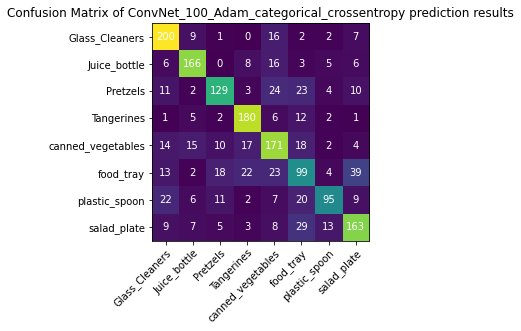

time: 326 ms


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

Ypred = np.argmax(results, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(name)

print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

fig, ax = plt.subplots()

confusion = tf.math.confusion_matrix(Ytest, Ypred)
img = ax.imshow(confusion)

ax.set_xticks(np.arange(len(classnames)))
ax.set_xticklabels(classnames)

ax.set_yticks(np.arange(len(classnames)))
ax.set_yticklabels(classnames)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

nda_confusion = np.array(confusion)

for i in range(len(classnames)):
    for j in range(len(classnames)):
        text = ax.text(j, i, nda_confusion[i, j], ha="center", va="center", color="w")

ax.set_title("Confusion Matrix of "+name+" prediction results")
plt.show()